In [23]:
import csv
from sklearn import svm
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)

In [2]:
def getSubsets(xRemain, yRemain, percentGap):
    initLength = len(xRemain)
    finArr = []
    curPercent = percentGap
    while curPercent < 1:
        
        (Xtrain,xRemain,Ytrain,yRemain) = model_selection.train_test_split(xRemain, yRemain, test_size= 1 - initLength / len(xRemain)  * percentGap)
        #print(initLength / len(xRemain)  * percentGap, len(Xtrain), len(xRemain) / initLength )
        curPercent += percentGap
        finArr.append([Xtrain, Ytrain])
    return finArr

In [18]:
totalValAccI = []
totalValAccR = []
for i in range(4):
    subsets = getSubsets(compoundDataTrain, classTrain, .1)
    curX = subsets[0][0]
    curY = subsets[0][1]

    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )


    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA

    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

    accuracy = 0
    while(accuracy < .7):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model2 = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])
        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
        model2.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

        history = model.fit(Xtrain, curY, validation_data = (valData, classVal), epochs=10, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
        accuracy = np.mean(predictionsTrain == curY)
        acc = [history.history['accuracy'][-1]]
        val_acc = [history.history['val_accuracy'][-1]]

        history2 = model2.fit(Xtrain, curY, validation_data = (valData, classVal), epochs=10, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model2.predict(Xtrain), axis=1)
        accuracy = np.mean(predictionsTrain == curY)
        acc2 = [history2.history['accuracy'][-1]]
        val_acc2 = [history2.history['val_accuracy'][-1]]

    total_epochs =  10
    for i in range(1, len(subsets)):
        curX = np.append(curX,subsets[i][0], axis = 0)
        curY = np.append(curY,subsets[i][1], axis = 0)
        total_epochs += 10
        print("Data length:", len(curX))
        labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16], muted = True)

        labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
        _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
        _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

        labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
        _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
        _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

        #after transformations are done assign data
        dataLabels = labelsMaxPCA
        trainData = trainMaxPCA
        testData = testMaxPCA
        valData = valMaxPCA
        print("Epochs: ", total_epochs)
        print("Data length:", len(curX))

        Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
        history = model.fit(Xtrain, curY,initial_epoch=total_epochs - 10, validation_data = (valData, classVal), epochs=total_epochs, batch_size=4, verbose = 0)
        history2 = model2.fit(Xtrain, curY, validation_data = (valData, classVal), epochs=total_epochs, batch_size=4, verbose = 0)

        #print(history.history['accuracy'][-1])
        acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        acc2.append(history2.history['accuracy'][-1])
        val_acc2.append(history2.history['val_accuracy'][-1])
        #print(val_acc, val_acc2)
    totalValAccI.append(val_acc)
    totalValAccR.append(val_acc2)
#print(model)
finI = np.array(totalValAccI[0])
finR = np.array(totalValAccR[0])
for i in range(1, len(totalValAccI)):
    finI += np.array(totalValAccI[i])
    finR += np.array(totalValAccR[i])
finI /= len(totalValAccI)
finR /= len(totalValAccR)

9/9 [==============================] - 0s 2ms/step
Data length: 542
Epochs:  20
Data length: 542
Data length: 813
Epochs:  30
Data length: 813
Data length: 1084
Epochs:  40
Data length: 1084
Data length: 1355
Epochs:  50
Data length: 1355
Data length: 1626
Epochs:  60
Data length: 1626
Data length: 1897
Epochs:  70
Data length: 1897
Data length: 2168
Epochs:  80
Data length: 2168
Data length: 2439
Epochs:  90
Data length: 2439
Data length: 2710
Epochs:  100
Data length: 2710
9/9 [==============================] - 0s 5ms/step
Data length: 542
Epochs:  20
Data length: 542
Data length: 813
Epochs:  30
Data length: 813
Data length: 1084
Epochs:  40
Data length: 1084
Data length: 1355
Epochs:  50
Data length: 1355
Data length: 1626
Epochs:  60
Data length: 1626
Data length: 1897
Epochs:  70
Data length: 1897
Data length: 2168
Epochs:  80
Data length: 2168
Data length: 2439
Epochs:  90
Data length: 2439
Data length: 2710
Epochs:  100
Data length: 2710
9/9 [==============================] - 0

Iterative VAcc:  [0.8617647  0.88088234 0.86764707 0.89705881 0.90955882 0.90735294
 0.90147059 0.9110294  0.91470589 0.91323528]
Resetting VAcc:  [0.87058824 0.86911765 0.88161765 0.89044118 0.89926471 0.90220587
 0.90441176 0.90882353 0.90441176 0.92132352]


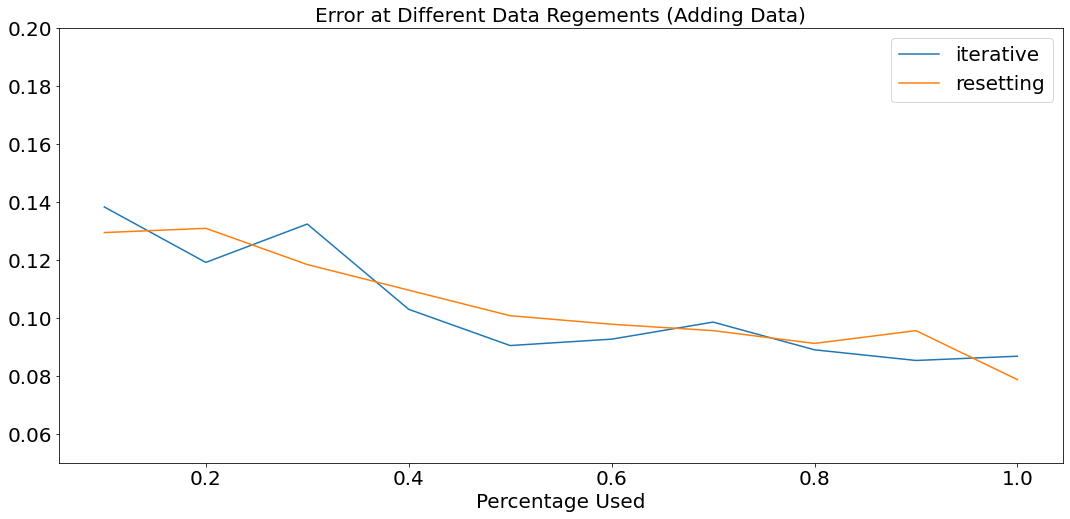

In [21]:
print("Iterative VAcc: ", finI)
print("Resetting VAcc: ", finR)

X = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
#for i in range (1, int(total_epochs / 10)):
#    X.append(i * 10)
fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#plt.vlines(x = X, color = 'r', ymin = 0.05, ymax = 0.2, linestyle = "dashed", alpha = 0.5)
ax.plot(X,1 - np.array(finI), label = "iterative")
ax.plot(X,1 - np.array(finR), label = "resetting")
ax.set_title("Error at Different Data Regements (Adding Data)",fontsize=20)
ax.set_xlabel("Percentage Used",fontsize=20)
ax.set_ylim(bottom = 0.05, top = 0.2)
ax.legend(fontsize = 20)

In [17]:
arr = [[0,1],[1,0]]
test = np.array([0,1])
test2 = np.array([1,0])
test += test2
print(test)
print(np.mean(arr))

[1 1]
0.5


In [12]:
subsets = getSubsets(compoundDataTrain, classTrain, .1)
curX = subsets[0][0]
curY = subsets[0][1]

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)


labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

accuracy = 0
while(accuracy < .7):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

    
    history = model.fit(Xtrain, curY, validation_data = (valData, classVal), epochs=10, batch_size=4, verbose = 1)
    predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
    accuracy = np.mean(predictionsTrain == curY)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
total_epochs =  10
for i in range(1, len(subsets)):
    curX = subsets[i][0]
    curY = subsets[i][1]
    total_epochs += 10
    print("Data length:", len(curX))
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA
    print("Epochs: ", total_epochs)
    print("Data length:", len(curX))
    
    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
    history = model.fit(Xtrain, curY,initial_epoch=total_epochs - 10, validation_data = (valData, classVal), epochs=total_epochs, batch_size=4, verbose = 1)
    
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']


Epoch 1/10
68/68 [==============================] - 1s 6ms/step - loss: 8.2791 - accuracy: 0.6863 - val_loss: 5.6180 - val_accuracy: 0.7941
Epoch 2/10
68/68 [==============================] - 0s 5ms/step - loss: 4.0436 - accuracy: 0.8745 - val_loss: 3.0901 - val_accuracy: 0.8529
Epoch 3/10
68/68 [==============================] - 0s 4ms/step - loss: 2.5184 - accuracy: 0.8930 - val_loss: 2.2591 - val_accuracy: 0.8500
Epoch 4/10
68/68 [==============================] - 0s 4ms/step - loss: 1.8749 - accuracy: 0.9188 - val_loss: 1.8479 - val_accuracy: 0.8588
Epoch 5/10
68/68 [==============================] - 0s 4ms/step - loss: 1.4975 - accuracy: 0.9410 - val_loss: 1.6140 - val_accuracy: 0.8412
Epoch 6/10
68/68 [==============================] - 0s 5ms/step - loss: 1.2411 - accuracy: 0.9594 - val_loss: 1.4931 - val_accuracy: 0.8618
Epoch 7/10
68/68 [==============================] - 0s 5ms/step - loss: 1.0843 - accuracy: 0.9594 - val_loss: 1.4189 - val_accuracy: 0.8794
Epoch 8/10
68/68 [==

In [ ]:
X = []
for i in range (1, int(total_epochs / 10)):
    X.append(i * 10)
fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.vlines(x = X, color = 'r', ymin = 0.05, ymax = 0.2, linestyle = "dashed", alpha = 0.5)
ax.plot(1 - np.array(val_acc))
ax.set_title("Error at Different Data Regements (Replacing Data)",fontsize=20)
ax.set_xlabel("Epochs",fontsize=20)
ax.set_ylim(bottom = 0.05, top = 0.2)

## Verifying Jesse's Code
Not that your code would ever any bugs

In [39]:
model = load_model('AddingPLANN.h5')

compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)
labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)
#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)

In [43]:
model.evaluate(trainData, classTrain)
model.evaluate(valData, classVal)

11/11 [==============================] - 0s 2ms/step - loss: 38725868.0000 - accuracy: 0.3912


[38725868.0, 0.3911764621734619]